<a href="https://colab.research.google.com/github/DanaZaretska/AudioAuthentification/blob/master/Model_Siamese_Images_filterupd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons==0.16.1

import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import pandas as pd
from glob import glob
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)

# Новий розділ

In [ ]:
def get_filenames(root_to_set, num: int):
  dir_path = root_to_set + '/speaker{}'.format(num)
  file_pathes = glob(dir_path + '/*')
  return [num, file_pathes]

def read_image(path):
  img = cv2.imread(path, 0)
  return img / 255

In [ ]:
def make_X_set(filepathes):
  X = []

  for path in filepathes:
    X.append(read_image(path))

  return np.array(X), filepathes

In [ ]:
data_root = '/content/drive/MyDrive/train_data/'
speakers = np.asarray(sorted([path.replace('\\', '/').split('/')[-1] for path in glob(data_root + '*')]))
nums = [int(speaker[-2:]) for speaker in speakers]

In [ ]:
x_train_filepathes = [glob(data_root + speaker + '/*.jpg')[:-10] for speaker in speakers]
x_test_filepathes = [glob(data_root + speaker + '/*.jpg')[-10:-5] for speaker in speakers]
x_val_filepathes = [glob(data_root + speaker + '/*.jpg')[-5:] for speaker in speakers]

In [ ]:
a = [len(i) for i in x_train_filepathes]
np.max(a), np.min(a), np.mean(a)

(53, 5, 21.325581395348838)

In [ ]:
x_train = [read_image(path) for speaker_paths in x_train_filepathes for path in speaker_paths]
print(1)
x_test = [read_image(path) for speaker_paths in x_test_filepathes for path in speaker_paths]
print(1)
x_val = [read_image(path) for speaker_paths in x_val_filepathes for path in speaker_paths]

1
1


In [ ]:
len(x_train), len(x_val), len(x_test)

(917, 215, 215)

In [ ]:
def make_indices(filepathes):

  indices = []
  start = 0

  for speaker in filepathes:
    arr = [el for el in range(start, start + len(speaker))]
    indices.append(arr)
    start += len(speaker)
  return indices

In [ ]:
x_train_indices = make_indices(x_train_filepathes)
x_val_indices = make_indices(x_val_filepathes)
x_test_indices = make_indices(x_test_filepathes)

In [ ]:
# x_train_indices

In [ ]:
len(x_train_indices)

43

In [ ]:
len(x_train_indices), len(x_test_indices), len(x_val_indices)

(43, 43, 43)

In [ ]:
def make_Y_set(x_indices):
    Y = []
    idx = 0

    for speaker in x_indices:
      for part in speaker:
        Y.append(nums[idx])
      idx += 1

    return np.array(Y)

In [ ]:
y_train = make_Y_set(x_train_indices)
y_val = make_Y_set(x_val_indices)
y_test = make_Y_set(x_test_indices)

In [ ]:
def make_pairs(x, y, indices):

    num_classes = 43
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idxs_to_choice = indices[nums.index(label1)].copy()
        idx2 = random.choice(idxs_to_choice)
        while idx2 == idx1:
          idx2 = random.choice(idxs_to_choice)

        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.choice(nums)
        while label2 == label1:
            label2 = random.choice(nums)

        idx2 = random.choice(indices[nums.index(label2)])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [ ]:
# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train, x_train_indices)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val, x_val_indices)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test, x_test_indices)

In [ ]:
len(pairs_train)

1834

In [ ]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((217, 334, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (3, 3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(4, (3, 3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(32, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((217, 334, 1))
input_2 = layers.Input((217, 334, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
embedding_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 217, 334, 1)]     0         
                                                                 
 batch_normalization (BatchN  (None, 217, 334, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 215, 332, 4)       40        
                                                                 
 average_pooling2d (AverageP  (None, 107, 166, 4)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 164, 16)      592       
                                                                 
 average_pooling2d_1 (Averag  (None, 52, 82, 16)       0     

In [ ]:
batch_size = 24

In [ ]:
siamese.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss(),
    metrics=["accuracy"])

siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 217, 334, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 217, 334, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 32)           145248      ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [ ]:
x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]

x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=15
)

Epoch 1/15
77/77 [==============================] - 18s 56ms/step - loss: 0.9927 - accuracy: 0.7612 - val_loss: 0.9979 - val_accuracy: 0.5349
Epoch 2/15
77/77 [==============================] - 3s 34ms/step - loss: 0.9701 - accuracy: 0.9188 - val_loss: 0.9765 - val_accuracy: 0.8326
Epoch 3/15
77/77 [==============================] - 3s 37ms/step - loss: 0.9299 - accuracy: 0.9607 - val_loss: 0.9555 - val_accuracy: 0.8744
Epoch 4/15
77/77 [==============================] - 3s 34ms/step - loss: 0.8722 - accuracy: 0.9733 - val_loss: 0.8921 - val_accuracy: 0.9512
Epoch 5/15
77/77 [==============================] - 3s 33ms/step - loss: 0.8015 - accuracy: 0.9858 - val_loss: 0.8612 - val_accuracy: 0.9535
Epoch 6/15
77/77 [==============================] - 2s 32ms/step - loss: 0.7184 - accuracy: 0.9929 - val_loss: 0.8175 - val_accuracy: 0.9488
Epoch 7/15
77/77 [==============================] - 2s 32ms/step - loss: 0.6258 - accuracy: 0.9924 - val_loss: 0.7792 - val_accuracy: 0.9442
Epoch 8/15
7

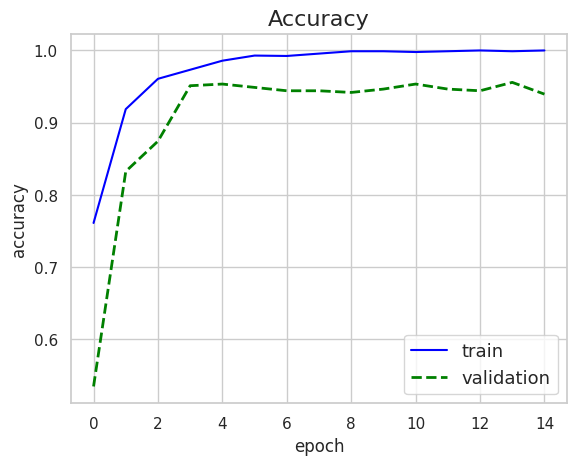

In [ ]:
import seaborn as sns
sns.set()

sns.set_palette(['blue', 'green'])
sns.set_style('whitegrid')

def plt_metric(history, metric, title, imname, has_valid=True):

    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric], linestyle = '--', linewidth = 2)
        plt.legend(["train", "validation"], fontsize=13)
    plt.title(title, fontsize=16)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.savefig(imname)
    # plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy", imname='acc.png')

# Plot the constrastive loss
# plt_metric(history=history.history, metric="loss", title="Triplet Loss", imname='loss.png')


In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

14/14 [==============================] - 1s 26ms/step - loss: 0.6020 - accuracy: 0.9581
test loss, test acc: [0.6019527912139893, 0.9581395387649536]


In [ ]:
results

[0.6019527912139893, 0.9581395387649536]

In [ ]:
predictions = siamese.predict([x_test_1, x_test_2])

14/14 [==============================] - 0s 10ms/step


In [ ]:
predictions_train = siamese.predict([x_train_1, x_train_2])

58/58 [==============================] - 1s 13ms/step


In [ ]:
predictions_thresholded = []

for num in predictions:
  if num > 0.5:
    prediction = 1
  else:
    prediction = 0

  predictions_thresholded.append(prediction)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, r2_score, roc_auc_score, average_precision_score, f1_score, det_curve, zero_one_loss,  brier_score_loss, confusion_matrix
from sklearn.metrics import matthews_corrcoef

print(accuracy_score(labels_test, predictions_thresholded))
print(r2_score(labels_test, predictions_thresholded))
print(roc_auc_score(labels_test, predictions_thresholded))
print(average_precision_score(labels_test, predictions_thresholded))
print(det_curve(labels_test, predictions_thresholded))
print(zero_one_loss(labels_test, predictions_thresholded))
print(f1_score(labels_test, predictions_thresholded))
print(matthews_corrcoef(labels_test, predictions_thresholded))
print(classification_report(labels_test, predictions_thresholded))

confusion_matrix(labels_test, predictions_thresholded)



0.958139534883721
0.8325581395348838
0.958139534883721
0.9227467811158798
(array([0.08372093]), array([0.]), array([1]))
0.041860465116279055
0.9598214285714286
0.9195072388142247
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96       215
         1.0       0.92      1.00      0.96       215

    accuracy                           0.96       430
   macro avg       0.96      0.96      0.96       430
weighted avg       0.96      0.96      0.96       430



array([[197,  18],
       [  0, 215]])

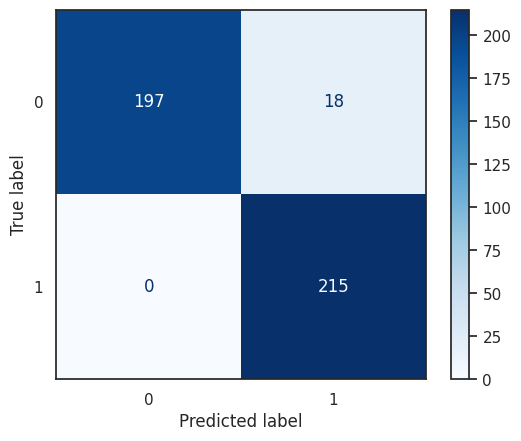

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, DetCurveDisplay, confusion_matrix
sns.set_style('white')
cm = confusion_matrix(labels_test, predictions_thresholded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# plt.savefig('conf_m.jpg')

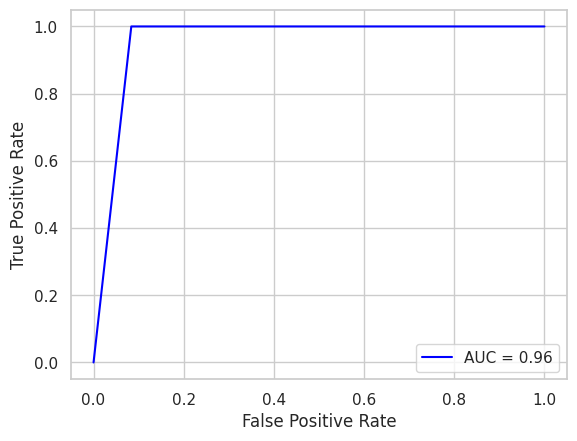

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(labels_test, predictions_thresholded)
roc_auc = auc(fpr, tpr)

# fpr, tpr, thresholds = roc_curve(labels_train, predictions_thresholded)
# roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.savefig('auc.png')
# plt.show()

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(10, 10))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

14/14 [==============================] - 0s 18ms/step


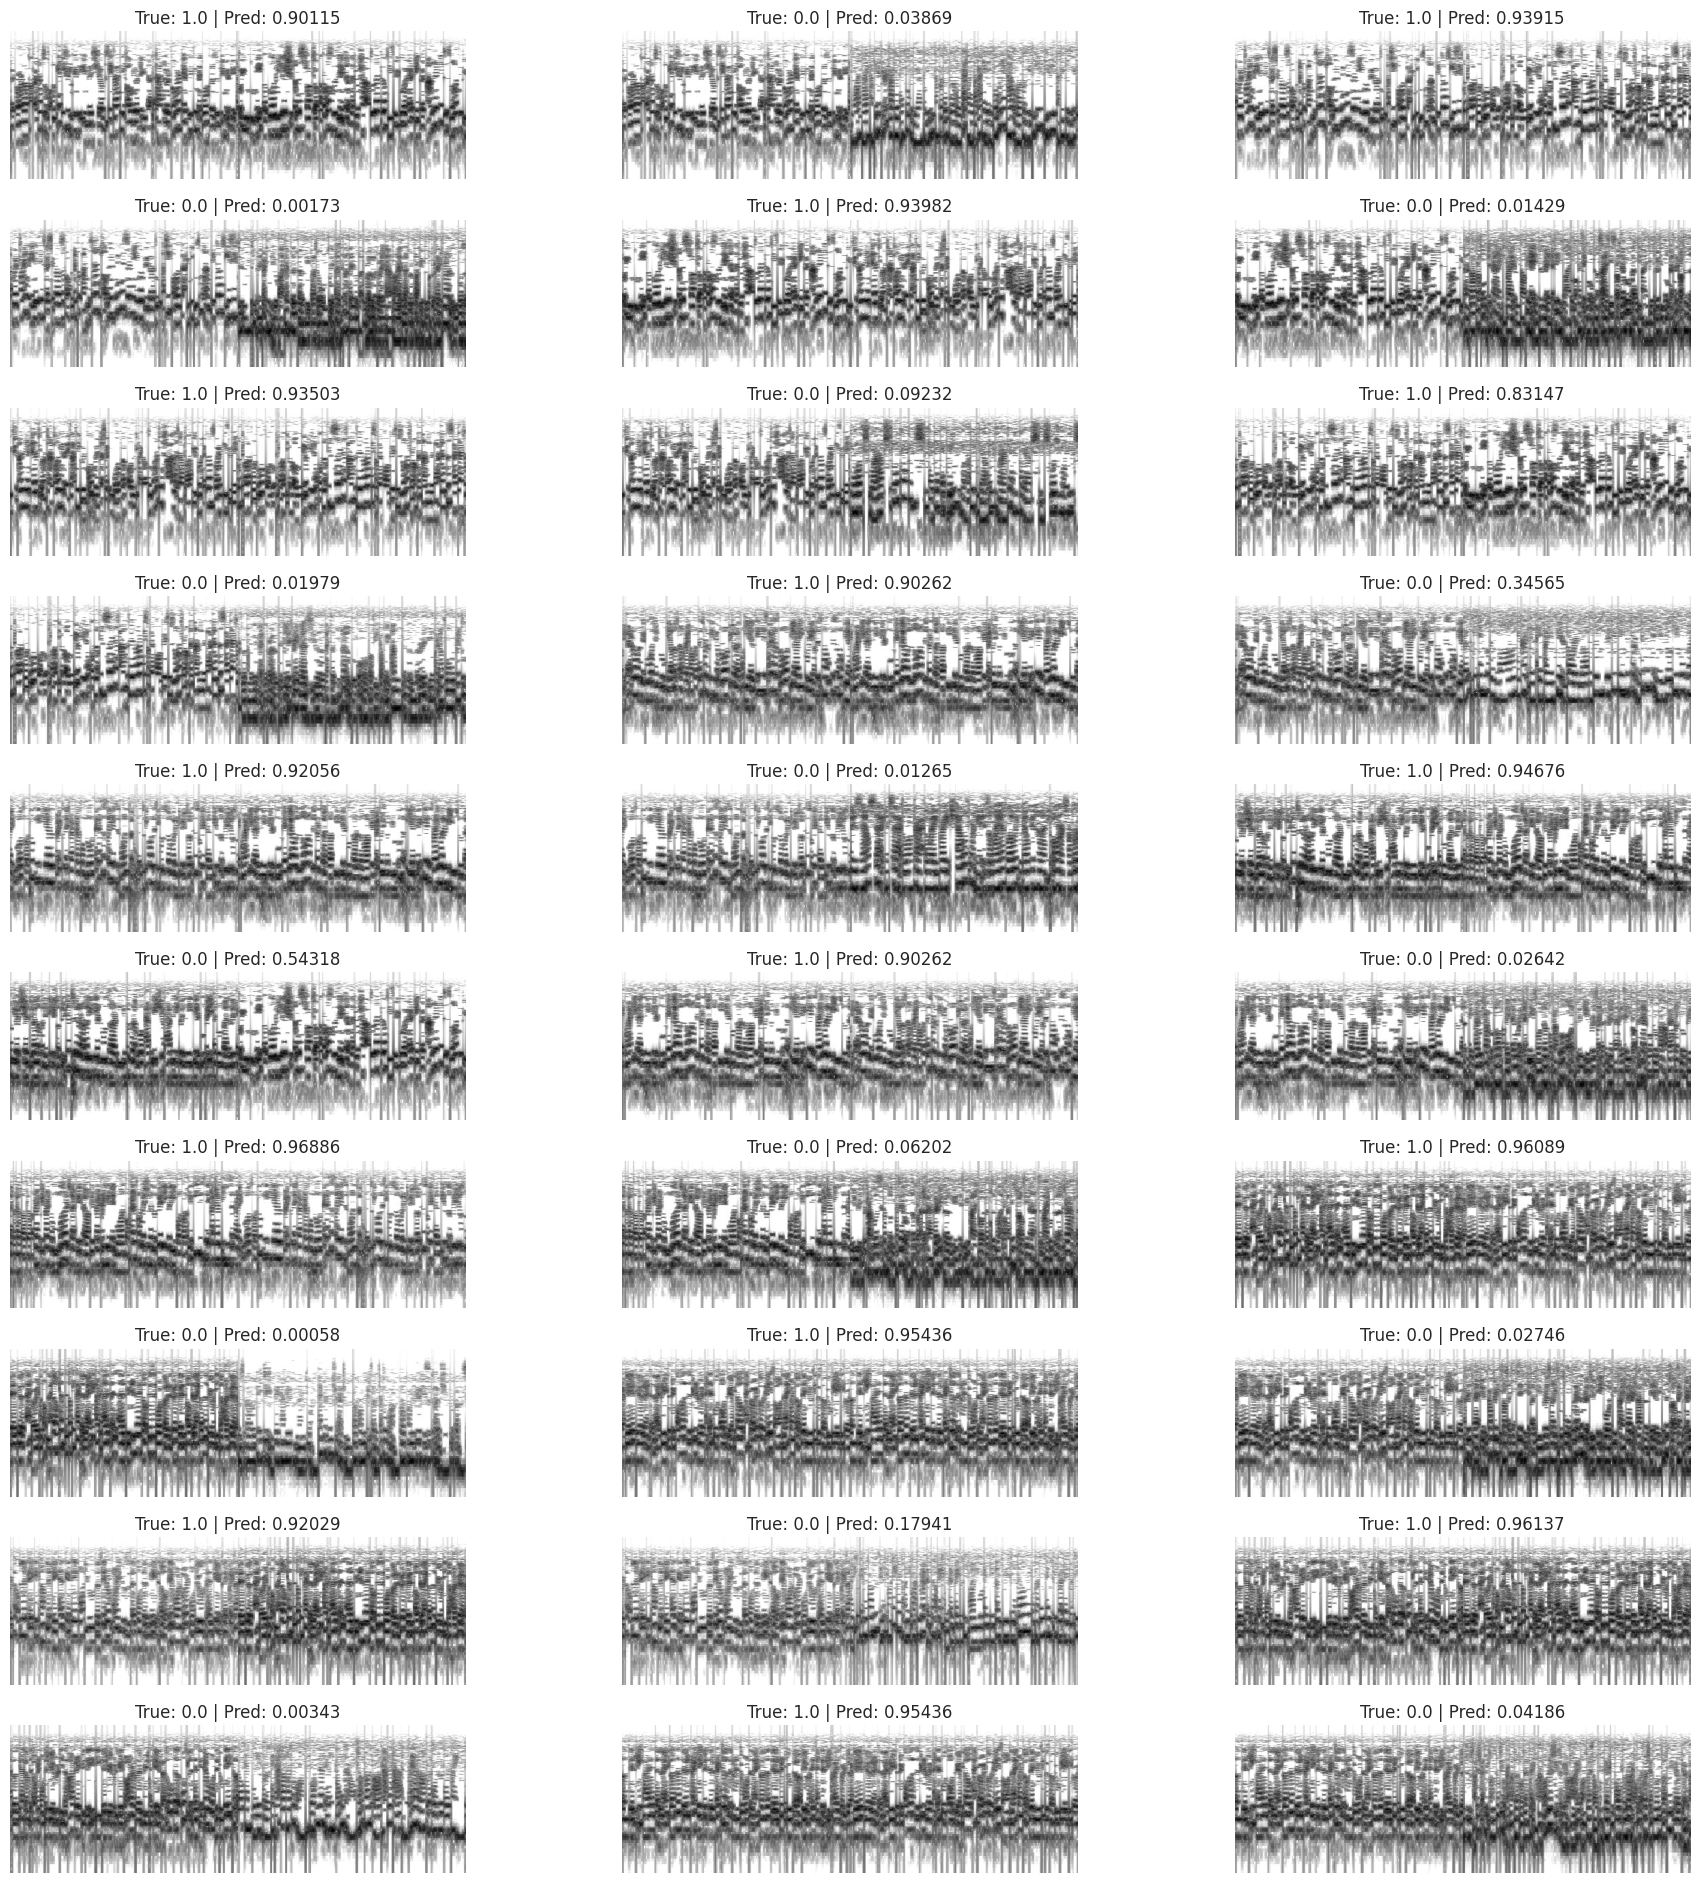

In [ ]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=30, predictions=predictions, test=True)

In [ ]:
predictions_diff = []

for i in range(len(labels_test)):
  predictions_diff.append(labels_test[i] - predictions[i][0])

predictions_diff = np.array(predictions_diff)
predictions_diff.sort()

In [ ]:
# predictions_diff

In [ ]:
# siamese.save('model.h5')

In [ ]:
# mdl = keras.models.load_model('model.h5')